In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 81.6 MB/s eta 0:00:00


In [2]:
!pip install adabelief-pytorch==0.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import re
import numpy as np
from tqdm import tqdm
from glob import glob
import json
import requests
import tensorflow as tf
from transformers import BertModel, TFBertModel, TFRobertaModel, RobertaTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, AutoModelForSequenceClassification
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from adabelief_pytorch import AdaBelief
from transformers.optimization import get_cosine_schedule_with_warmup
from tqdm import tqdm, tqdm_notebook
import shutil
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [4]:
#random seed 고정
tf.random.set_seed(2023)
np.random.seed(2023)
BATCH_SIZE = 32
NUM_EPOCHS = 1

L_RATE = 1e-05
MAX_LEN = 128
max_grad_norm=1
log_interval=200
NUM_CORES = os.cpu_count()
device = torch.device("cuda:0")

In [7]:
#model = AutoModelForSequenceClassification.from_pretrained("klue/roberta-base",num_labels=10)
model = torch.load('/content/drive/MyDrive/NLP/Models/klue_roberta_base_sota_model_e3.pth')
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-base")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/NLP/Data/최종학습데이터세트_병합ver_전처리전단계_0116.csv',encoding = 'utf-8')
data.drop('하위 카테고리',axis = 1,inplace = True)
data['카테고리'] = data['카테고리'].replace(['생활/건강','스포츠/레저','식품','여가/생활편의', '가구/인테리어', '디지털/가전', '패션의류','패션잡화', '화장품/미용', '출산/육아'],[0,1,2,3,4,5,6,7,8,9])

Mounted at /content/drive


In [9]:
from sklearn.model_selection import train_test_split

X_data = data['품목명']
y_data = data['카테고리']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=2023, stratify=y_data)

In [10]:
train_data = pd.DataFrame([ x for x in zip(X_train,y_train)])
train_data.columns = ['품목명','label']

In [11]:
import re
# 데이터 전처리 
# 괄호(),[],<> 안에 들어가있는 문자들 제거
train_data.replace('\[[^]]*\]', '', regex=True,inplace=True)
train_data.replace('\([^]]*\)', '', regex=True,inplace=True)
train_data.replace('\<[^]]*\>', '', regex=True,inplace=True)

# 특수문자를 띄어쓰기로 대체(특수문자: 영어, 한글, 숫자 제외한 문자들)
train_data['품목명']=train_data['품목명'].apply(lambda x: re.compile(r'[^A-Za-z0-9가-힣]').sub(' ',x))

# 숫자를 공백(띄어쓰기 없음)으로 대체
train_data['품목명']=train_data['품목명'].apply(lambda x: re.compile(r'[0-9]').sub('',x))

# 숫자를 공백으로 대체한 후, 중복값 제거
train_data.drop_duplicates(['품목명'], keep = 'first',ignore_index = True, inplace=True)

# 알파벳 길이가 1인 문자 제거
train_data['품목명']=train_data['품목명'].apply(lambda x: re.compile(r'(?<=\s)([A-Za-z])(?=\s)').sub(' ',x))

In [12]:
X_train, X_val, y_train, y_val = train_test_split(train_data['품목명'], train_data['label'], 
                                                    test_size = 0.2, 
                                                    random_state = 2023, 
                                                    stratify = train_data['label'])

In [13]:
train_data = pd.DataFrame([ x for x in zip(X_train,y_train)])
train_data.columns = ['품목명','label']

valid_data = pd.DataFrame([ x for x in zip(X_val,y_val)])
valid_data.columns = ['품목명','label']


test_data = pd.DataFrame([ x for x in zip(X_test,y_test)])
test_data.columns = ['품목명','label']

In [14]:
class TrainDataset(Dataset):
    def __init__(self, df):
        self.df_data = df
    def __getitem__(self, index):
        # get the sentence from the dataframe
        sentence = self.df_data.loc[index, '품목명']
        encoded_dict = tokenizer(
          text = sentence,
          add_special_tokens = True, 
          max_length = MAX_LEN,
          padding = 'max_length',
          truncation=True,           # Pad & truncate all sentences.
          return_tensors="pt")

        padded_token_list = encoded_dict['input_ids'][0]
        token_type_id = encoded_dict['token_type_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]
        target = torch.tensor(self.df_data.loc[index, "label"])
        sample = (padded_token_list, token_type_id , att_mask, target)
        return sample
    def __len__(self):
        return len(self.df_data)

In [15]:
class ValidDataset(Dataset):
    def __init__(self, df):
        self.df_data = df
    def __getitem__(self, index):
        # get the sentence from the dataframe
        sentence = self.df_data.loc[index, '품목명']
        encoded_dict = tokenizer(
          text = sentence,
          add_special_tokens = True, 
          max_length = MAX_LEN,
          padding = 'max_length',
          truncation=True,           # Pad & truncate all sentences.
          return_tensors="pt")

        padded_token_list = encoded_dict['input_ids'][0]
        token_type_id = encoded_dict['token_type_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]
        target = torch.tensor(self.df_data.loc[index, "label"])
        sample = (padded_token_list, token_type_id , att_mask, target)
        return sample
    def __len__(self):
        return len(self.df_data)

In [16]:
class TestDataset(Dataset):
    def __init__(self, df):
        self.df_data = df
    def __getitem__(self, index):
        # get the sentence from the dataframe
        sentence = self.df_data.loc[index, '품목명']
        encoded_dict = tokenizer(
          text = sentence,
          add_special_tokens = True, 
          max_length = MAX_LEN,
          padding = 'max_length',
          truncation=True,           # Pad & truncate all sentences.
          return_tensors="pt")

        padded_token_list = encoded_dict['input_ids'][0]
        token_type_id = encoded_dict['token_type_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]
        sample = (padded_token_list, token_type_id , att_mask)
        return sample
    def __len__(self):
        return len(self.df_data)

In [19]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [20]:
train_data = TrainDataset(train_data)

valid_data = ValidDataset(valid_data)

test_data = TestDataset(test_data)

train_dataloader = torch.utils.data.DataLoader(train_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                      num_workers=NUM_CORES)
valid_dataloader = torch.utils.data.DataLoader(valid_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                      num_workers=NUM_CORES)
test_dataloader = torch.utils.data.DataLoader(test_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                      num_workers=NUM_CORES)


In [21]:
model.to(device)
optimizer = AdaBelief(model.parameters(), lr=5e-5, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False)

warmup_ratio = 0.1
t_total = len(train_dataloader) * NUM_EPOCHS
warmup_step = int(t_total * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [ ]:
for e in range(NUM_EPOCHS):
    train_acc = 0.0
    valid_acc = 0.0
    model.train()
    torch.set_grad_enabled(True)
    for batch_id, (input_id,token_type_id,attention_mask,label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        input_id = input_id.long().to(device)
        token_type_id = token_type_id.long().to(device)
        attention_mask = attention_mask.long().to(device)
        label = label.to(device)
        outputs = model(input_ids=input_id, token_type_ids=token_type_id, attention_mask=attention_mask, labels=label)
        loss = outputs[0]
        out = outputs[1]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    for batch_id, (input_id,token_type_id,attention_mask,label) in enumerate(tqdm_notebook(valid_dataloader)):
        optimizer.zero_grad()
        input_id = input_id.long().to(device)
        token_type_id = token_type_id.long().to(device)
        attention_mask = attention_mask.long().to(device)
        label = label.to(device)
        outputs = model(input_ids=input_id, token_type_ids=token_type_id, attention_mask=attention_mask, labels=label)
        loss = outputs[0]
        out = outputs[1]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        
        valid_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} valid acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), valid_acc / (batch_id+1)))
    print("epoch {} valid acc {}".format(e+1, valid_acc / (batch_id+1)))


preds = [] 
model.eval()
torch.set_grad_enabled(False)
for batch_id, (input_id,token_type_id,attention_mask) in enumerate(tqdm_notebook(test_dataloader)):
    input_id = input_id.long().to(device)
    token_type_id = token_type_id.long().to(device)
    attention_mask = attention_mask.long().to(device)
    outputs = model(input_ids=input_id, token_type_ids=token_type_id, attention_mask=attention_mask)
    out = outputs[0]
    for inp in out:
      preds.append(inp.detach().cpu().numpy())
Preds = np.array(preds)

<ipython-input-21-c637f46d712a>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (input_id,token_type_id,attention_mask,label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/23018 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

epoch 1 batch id 1 loss 0.00761385215446353 train acc 1.0
epoch 1 batch id 201 loss 0.019748035818338394 train acc 0.9741915422885572
epoch 1 batch id 401 loss 0.10797157883644104 train acc 0.9747506234413965
epoch 1 batch id 601 loss 0.2333185374736786 train acc 0.9746776206322796
epoch 1 batch id 801 loss 0.009257632307708263 train acc 0.9748361423220974
epoch 1 batch id 1001 loss 0.021673573181033134 train acc 0.9749313186813187
epoch 1 batch id 1201 loss 0.23692753911018372 train acc 0.9749687760199833
epoch 1 batch id 1401 loss 0.09172463417053223 train acc 0.9745717344753747
epoch 1 batch id 1601 loss 0.007825127802789211 train acc 0.9738444722048719
epoch 1 batch id 1801 loss 0.1426970213651657 train acc 0.9728970016657412
epoch 1 batch id 2001 loss 0.009079399518668652 train acc 0.9726542978510745
epoch 1 batch id 2201 loss 0.005765508860349655 train acc 0.9722711267605634
epoch 1 batch id 2401 loss 0.06938809901475906 train acc 0.9715613286130779
epoch 1 batch id 2601 loss 0.1

<ipython-input-21-c637f46d712a>:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (input_id,token_type_id,attention_mask,label) in enumerate(tqdm_notebook(valid_dataloader)):


  0%|          | 0/5755 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

epoch 1 batch id 1 loss 0.26160067319869995 valid acc 0.9375
epoch 1 batch id 201 loss 0.22970809042453766 valid acc 0.970771144278607
epoch 1 batch id 401 loss 0.0033852560445666313 valid acc 0.9689837905236908
epoch 1 batch id 601 loss 0.01748238317668438 valid acc 0.9689579866888519
epoch 1 batch id 801 loss 0.04102298244833946 valid acc 0.9691011235955056
epoch 1 batch id 1001 loss 0.237240731716156 valid acc 0.9695616883116883
epoch 1 batch id 1201 loss 0.10341708362102509 valid acc 0.9696867194004996
epoch 1 batch id 1401 loss 0.17836877703666687 valid acc 0.9699098857958601
epoch 1 batch id 1601 loss 0.2596668004989624 valid acc 0.9694917239225485
epoch 1 batch id 1801 loss 0.18572719395160675 valid acc 0.9692705441421433
epoch 1 batch id 2001 loss 0.024237599223852158 valid acc 0.9689998750624688
epoch 1 batch id 2201 loss 0.028848718851804733 valid acc 0.9686506133575647
epoch 1 batch id 2401 loss 0.010656990110874176 valid acc 0.9687760308204915
epoch 1 batch id 2601 loss 0.1

<ipython-input-21-c637f46d712a>:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (input_id,token_type_id,attention_mask) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/13032 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

KeyboardInterrupt: ignored

In [ ]:
torch.save(model,'/content/drive/MyDrive/NLP/Models/' + 'klue_roberta_base_sota_model_e3.pth')  # 전체 모델 저장

In [22]:
preds = [] 
model.eval()
torch.set_grad_enabled(False)
for batch_id, (input_id,token_type_id,attention_mask) in enumerate(tqdm_notebook(test_dataloader)):
    input_id = input_id.long().to(device)
    token_type_id = token_type_id.long().to(device)
    attention_mask = attention_mask.long().to(device)
    outputs = model(input_ids=input_id, token_type_ids=token_type_id, attention_mask=attention_mask)
    out = outputs[0]
    for inp in out:
      preds.append(inp.detach().cpu().numpy())
Preds = np.array(preds)

<ipython-input-22-1a6cfaa9880c>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (input_id,token_type_id,attention_mask) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/13032 [00:00<?, ?it/s]

In [24]:
test_data = pd.DataFrame([ x for x in zip(X_test,y_test)])
test_data.columns = ['품목명','label']

In [25]:
#test_data에 예측값 Column 추가.
test_data['predict'] = np.argmax(Preds, axis=1)

In [26]:
test_data['label'] = test_data['label'].replace([0,1,2,3,4,5,6,7,8,9],['생활/건강','스포츠/레저','식품','여가/생활편의', '가구/인테리어', '디지털/가전', '패션의류','패션잡화', '화장품/미용', '출산/육아'],)
test_data['predict'] = test_data['predict'].replace([0,1,2,3,4,5,6,7,8,9],['생활/건강','스포츠/레저','식품','여가/생활편의', '가구/인테리어', '디지털/가전', '패션의류','패션잡화', '화장품/미용', '출산/육아'],)

In [27]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss
#classification report 확인.

cl_report = classification_report(test_data['predict'],test_data['label'], output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(10)
print(cl_report_df)

              precision    recall  f1-score       support
가구/인테리어        0.975421  0.968751  0.972074   32321.00000
디지털/가전         0.973441  0.969598  0.971516   54963.00000
생활/건강          0.930597  0.917760  0.924134   26751.00000
스포츠/레저         0.945474  0.964972  0.955123   48104.00000
식품             0.974356  0.975479  0.974917   34705.00000
여가/생활편의        0.902749  0.947275  0.924476   14111.00000
출산/육아          0.948107  0.947501  0.947804   59506.00000
패션의류           0.986142  0.980850  0.983489   81255.00000
패션잡화           0.974975  0.974452  0.974713   35423.00000
화장품/미용         0.973653  0.959707  0.966630   29881.00000
accuracy       0.964150  0.964150  0.964150       0.96415
macro avg      0.958491  0.960634  0.959488  417020.00000
weighted avg   0.964309  0.964150  0.964191  417020.00000


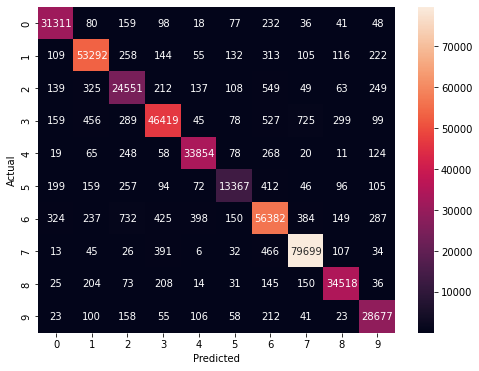

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

#classification matrix 확인 
cf_matrix = confusion_matrix(test_data['label'], test_data['predict'])
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cf_matrix, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
roberta_base_pred = Preds

In [34]:
np.save('/content/drive/MyDrive/NLP/Logs/roberta_base.npy',arr=roberta_base_pred)

In [ ]:
#roberta_base_pred = np.load('/content/drive/MyDrive/NLP/Logs/roberta_base.npy')

In [29]:
preds = [] 
bert_base_model.eval()
torch.set_grad_enabled(False)
for batch_id, (input_id,token_type_id,attention_mask) in enumerate(tqdm_notebook(test_dataloader)):
    input_id = input_id.long().to(device)
    token_type_id = token_type_id.long().to(device)
    attention_mask = attention_mask.long().to(device)
    outputs = model(input_ids=input_id, token_type_ids=token_type_id, attention_mask=attention_mask)
    out = outputs[0]
    for inp in out:
      preds.append(inp.detach().cpu().numpy())
Preds = np.array(preds)

In [32]:
bert_base_model.to(device)
optimizer = AdaBelief(bert_base_model.parameters(), lr=5e-5, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False)

warmup_ratio = 0.1
t_total = len(train_dataloader) * NUM_EPOCHS
warmup_step = int(t_total * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [33]:
preds = [] 
bert_base_model.eval()
torch.set_grad_enabled(False)
for batch_id, (input_id,token_type_id,attention_mask) in enumerate(tqdm_notebook(test_dataloader)):
    input_id = input_id.long().to(device)
    token_type_id = token_type_id.long().to(device)
    attention_mask = attention_mask.long().to(device)
    outputs = model(input_ids=input_id, token_type_ids=token_type_id, attention_mask=attention_mask)
    out = outputs[0]
    for inp in out:
      preds.append(inp.detach().cpu().numpy())
Preds = np.array(preds)

<ipython-input-33-a270bbdac8cc>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (input_id,token_type_id,attention_mask) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/13032 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
roberta_small_model.to(device)
optimizer = AdaBelief(roberta_small_model.parameters(), lr=5e-5, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False)

warmup_ratio = 0.1
t_total = len(train_dataloader) * NUM_EPOCHS
warmup_step = int(t_total * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)